In [4]:
!pip install biopython==1.79

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import random
from tqdm import tqdm
import time
import pickle
from matplotlib.colors import LinearSegmentedColormap
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import Align
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
!cp '/content/drive/MyDrive/Mag naloga/EPFL/genomic_distance/stu.fasta' '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/stu.fasta'

### GENOMIC DISTANCE

In [3]:
org_codes = [
    'ath', #thaliana
    'osa', #rice
    'stu', #potato
    'zma', #corn
]
ortholog_pairs = {'ath-osa':[], 'ath-stu':[], 'ath-zma':[], 'osa-stu':[], 'osa-zma':[], 'stu-zma':[]}

### Compute

In [ ]:
# align - higher is better, length dependant - needs normalization

In [4]:
ort_families = pd.read_csv('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/genefamily_data.ORTHOFAM.csv', sep='\t')
ort_families = ort_families[ort_families.species.isin(['ath', 'osa', 'stu', 'zma'])]
ort_families.sample(3)

,gf_id,species,gene_id
1181912,ORTHO05D000994,stu,PGSC0003DMG400020900
2085630,ORTHO05D004020,osa,Os02g0761600
1262184,ORTHO05D001158,zma,Zm00001eb103260


In [5]:
organism_data = []
for org in org_codes: organism_data.append(pd.read_csv(f'/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/annotation.all_transcripts.{org}.csv', sep='\t', low_memory=False))
organism_data = pd.concat(organism_data)
organism_data.drop(['transcript', 'coord_cds', 'coord_transcript', 'check_transcript', 'check_protein', 'transl_table', 'type'], axis=1, inplace=True)
organism_data = organism_data[~organism_data['chr'].str.contains('scaf_', na=False)]
organism_data.sample(3)

,gene_id,species,start,stop,seq,strand,chr
17201,PGSC0003DMG400022088,stu,20333267,20336351,ATGGCTTCTTCATCTTCTCTCACTCTTTCTCAAGCTATCTTCTCTC...,-,ST4.03ch10
57632,Zm00001eb233800,zma,91736224,91741600,ATGGAAGTTGAGCTGCCAAACATCCATAAAGCTACTTCGAGTGACC...,+,5
91244,AT5G66005,ath,26398286,26399123,ATGGCAGGCACCGGGAAATGCCTTCTTGTCACCGGCCCTCCTGGTG...,-,Chr5


In [6]:
# genomic sequences, tair10 same as araport11
ath = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/ath.fasta'
zma = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/zma.fasta'
osa = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/osa.fasta'
stu = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/stu.fasta'
genomic_sequences = {}
for organism, path in {'ath':ath,'osa':osa,'stu':stu,'zma':zma,}.items():
  sequence = {}
  for record in SeqIO.parse(path, "fasta"):
      if 'scaf' not in record.id: sequence[record.id] = record.seq
  genomic_sequences[organism] = sequence

In [7]:
ortholog_pairs = {'ath-osa':[], 'ath-stu':[], 'ath-zma':[], 'osa-stu':[], 'osa-zma':[], 'stu-zma':[]}
results = []
aligner = Align.PairwiseAligner()

for op in ortholog_pairs:
  spa, spb = op.split('-')
  # find ortolog gene families
  allorthologsa, allorthologsb = ort_families[ort_families.species == spa], ort_families[ort_families.species == spb]
  intersect = list(set(allorthologsa.gf_id.values).intersection(set(allorthologsb.gf_id.values)))
  print('intersect', len(intersect))
  for orthid in tqdm(intersect):  # for each ortholog family, get distance
    orthologsa, orthologsb = allorthologsa[allorthologsa.gf_id == orthid], allorthologsb[allorthologsb.gf_id == orthid]
    genesa = organism_data[(organism_data.species == spa) & (organism_data.gene_id.isin(orthologsa.gene_id.values))]
    genesb = organism_data[(organism_data.species == spb) & (organism_data.gene_id.isin(orthologsb.gene_id.values))]
    genesa, genesb = genesa[genesa.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])], genesb[genesb.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])]
    genesa, genesb = genesa[genesa.strand == '+'], genesb[genesb.strand == '+']
    if genesa.shape[0] == 0 or genesb.shape[0] == 0: continue

    for la in genesa.index:
      ageneid, aspecies, astart, astop, aseq, astrand, achr = genesa.loc[la]
      astart = int(astart)
      if astrand == '+': aupstream = genomic_sequences[spa][achr][astart-2000:astart]
      # elif astrand == '-': aupstream = genomic_sequences[spa][achr][astop:astop+2000].reverse_complement()
      for lb in genesb.index:
        bgeneid, bspecies, bstart, bstop, bseq, bstrand, bchr = genesb.loc[lb]
        bstart = int(bstart)
        s = aligner.score(aseq, bseq)
        if astrand == '+' and bstrand == '+':
          bupstream = genomic_sequences[spb][bchr][bstart-2000:bstart]
          sup = aligner.score(aupstream, bupstream) / ((len(aseq) + len(bseq))/2)
        else: sup = None
        results.append([op, 'ortholog', ageneid, aspecies, astart, astop, astrand, achr, bgeneid, bspecies, bstart, bstop, bstrand, bchr, orthid, s, sup])

  orthologsa, orthologsb = allorthologsa[allorthologsa.gf_id.isin(intersect)], allorthologsb[allorthologsb.gf_id.isin(intersect)]
  nonorth_genesa = organism_data[(organism_data.species == spa) & (~organism_data.gene_id.isin(orthologsa.gene_id.values))]
  nonorth_genesb = organism_data[(organism_data.species == spb) & (~organism_data.gene_id.isin(orthologsb.gene_id.values))]
  nonorth_genesa, nonorth_genesb = nonorth_genesa[nonorth_genesa.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])], nonorth_genesb[nonorth_genesb.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])]
  nonorth_genesa, nonorth_genesb = nonorth_genesa[nonorth_genesa.strand == '+'], nonorth_genesb[nonorth_genesb.strand == '+']
  print('non orth', min(nonorth_genesa.shape[0], nonorth_genesb.shape[0]))
  nonorth_genesa, nonorth_genesb = nonorth_genesa.sample(min(nonorth_genesa.shape[0], nonorth_genesb.shape[0])), nonorth_genesb.sample(min(nonorth_genesb.shape[0], nonorth_genesa.shape[0]))
  if nonorth_genesa.shape[0] == 0 or nonorth_genesb.shape[0] == 0: continue

  for i, la in tqdm(enumerate(nonorth_genesa.index)):
    ageneid, aspecies, astart, astop, aseq, astrand, achr = nonorth_genesa.loc[la]
    lb = nonorth_genesb.index[i]
    bgeneid, bspecies, bstart, bstop, bseq, bstrand, bchr = nonorth_genesb.loc[lb]
    s = aligner.score(aseq, bseq) / ((len(aseq) + len(bseq))/2)
    results.append([op, 'random', ageneid, aspecies, astart, astop, astrand, achr, bgeneid, bspecies, bstart, bstop, bstrand, bchr, None, s, None])

  # only test chr
  # genesa, genesb = genesa[genesa.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])], genesb[genesb.chr.isin(['Chr3', 'chr03', '3', 'ST4.03ch03'])]

intersect 8414


100%|██████████| 8414/8414 [14:39<00:00,  9.56it/s]


non orth 927


927it [00:04, 228.72it/s]


intersect 8368


100%|██████████| 8368/8368 [14:39<00:00,  9.51it/s]


non orth 671


671it [00:01, 365.71it/s]


intersect 8422


100%|██████████| 8422/8422 [15:56<00:00,  8.80it/s]


non orth 731


731it [00:03, 238.81it/s]


intersect 7949


100%|██████████| 7949/7949 [13:17<00:00,  9.96it/s]


non orth 706


706it [00:02, 342.22it/s]


intersect 9832


100%|██████████| 9832/9832 [16:35<00:00,  9.88it/s]


non orth 501


501it [00:01, 394.42it/s]


intersect 7945


100%|██████████| 7945/7945 [13:53<00:00,  9.53it/s]


non orth 717


717it [00:02, 265.95it/s]


In [8]:
comparison_out = pd.DataFrame(results, columns=['comparison_pair', 'comparison_type', 'ageneid', 'aspecies', 'astart', 'astop', 'astrand', 'achr', 'bgeneid', 'bspecies', 'bstart', 'bstop', 'bstrand', 'bchr', 'ortholog_id', 'gene_distance', 'upstream_distance'])

In [9]:
comparison_out.to_pickle('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/orthology_distances.pkl')

In [52]:
# test za vsak gen, performance random gen vs ortologni gen v ara, ampak samo tisti, kjer je TSS znan
to_test = comparison_out[comparison_out.comparison_pair.str.contains('ath')]

In [58]:
to_test[to_test.comparison_pair == 'ath-zma'][['ageneid', 'aspecies', 'astart', 'achr', 'bgeneid', 'bspecies', 'bstart', 'bchr', 'gene_distance']]

,ageneid,aspecies,astart,achr,bgeneid,bspecies,bstart,bchr,gene_distance
5478,AT3G23380,ath,8373947,Chr3,Zm00001eb143410,zma,163766890,3,334.000000
5479,AT3G23380,ath,8373947,Chr3,Zm00001eb143410,zma,163766890,3,334.000000
5480,AT3G23380,ath,8374118,Chr3,Zm00001eb143410,zma,163766890,3,314.000000
5481,AT3G23200,ath,8281659,Chr3,Zm00001eb148020,zma,184783672,3,311.000000
5482,AT3G23200,ath,8282134,Chr3,Zm00001eb148020,zma,184783672,3,271.000000
...,...,...,...,...,...,...,...,...,...
9433,AT3G28870,ath,10890355,Chr3,Zm00001eb127590,zma,35681096,3,0.462185
9434,AT3G17120,ath,5842410,Chr3,Zm00001eb163840,zma,236522392,3,0.593356
9435,AT3TE56465,ath,13784362,Chr3,Zm00001eb131440,zma,65906646,3,0.123195
9436,AT3G23450,ath,8410483,Chr3,Zm00001eb159010,zma,221742890,3,0.462807


### ORGANISM PAIRS PERFORMANCE

In [1]:
# THAL OK, MAYS NO, RICE OK, POTATO NO
ath = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/ath.fasta'
ath2 = '/content/drive/MyDrive/Mag naloga/EPFL/TAIR10_EPD/TAIR10_chr_all.fas'
zma = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/zma.fasta'
zma2 = '/content/drive/MyDrive/Mag naloga/EPFL/EPD ZMays/GCF_000005005.1_B73_RefGen_v3_genomic.fna'
osa = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/osa.fasta'
osa2 = '/content/drive/MyDrive/Mag naloga/EPFL/oryza/IRGSP-1.0_genome.fasta'
stu = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/stu.fasta'
stu2 = '/content/drive/MyDrive/Mag naloga/EPFL/potato/DM_1-3_516_R44_potato_genome_assembly.v6.1.fa'

In [21]:
sequence1, sequence2 = {}, {}
for record in SeqIO.parse(stu, "fasta"):
    if 'scaf' not in record.id and 'ch00' not in record.id: sequence1[record.id] = record.seq
print(sequence1.keys())
for record in SeqIO.parse(stu2, "fasta"):
    if 'scaf' not in record.id: sequence2[record.id] = record.seq
print(sequence2.keys())

dict_keys(['ST4.03ch01', 'ST4.03ch02', 'ST4.03ch03', 'ST4.03ch04', 'ST4.03ch05', 'ST4.03ch06', 'ST4.03ch07', 'ST4.03ch08', 'ST4.03ch09', 'ST4.03ch10', 'ST4.03ch11', 'ST4.03ch12'])
dict_keys(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12'])


In [22]:
for s in sequence1:
  ss = 'chr' + s[-2:]#f'NC_0244{58+int(s)}.1'
  ln = min(len(sequence1[s]), len(sequence2[ss]))
  if sequence1[s][:ln].upper() != sequence2[ss][:ln].upper():
    print(s,ss, len(sequence1[s]), len(sequence2[ss]), 'FALSE')

ST4.03ch01 chr01 88663952 88591686 FALSE
ST4.03ch02 chr02 48614681 46102915 FALSE
ST4.03ch03 chr03 62290286 60707570 FALSE
ST4.03ch04 chr04 72208621 69236331 FALSE
ST4.03ch05 chr05 52070158 55599697 FALSE
ST4.03ch06 chr06 59532096 59091578 FALSE
ST4.03ch07 chr07 56760843 57639317 FALSE
ST4.03ch08 chr08 56938457 59226000 FALSE
ST4.03ch09 chr09 61540751 67600300 FALSE
ST4.03ch10 chr10 59756223 61044151 FALSE
ST4.03ch11 chr11 45475667 46777387 FALSE
ST4.03ch12 chr12 61165649 59670755 FALSE


In [27]:
# for each gene-species, check if tss before start
# thal + rice
ricetss = '/content/drive/MyDrive/Mag naloga/EPFL/oryza/RICE_TSS_array_data.pkl'
thaltss = '/content/drive/MyDrive/Mag naloga/EPFL/TSS_array_data.pkl'
ricetss = pd.read_pickle(ricetss)['3']['+']
thaltss = pd.read_pickle(thaltss)['3']['+']

In [66]:
# tss has to be before
ricegenes = comparison_out[comparison_out.comparison_pair == 'ath-osa'][['bgeneid', 'bspecies', 'bstart', 'bchr']].drop_duplicates()
selectedrice = []
for i in ricegenes.index:
  _,_,start, chr = ricegenes.loc[i]
  start = int(start)
  if np.sum(ricetss[start-128:start]) > 0: selectedrice.append((i, np.nonzero(ricetss[start-128:start])))
ricegenes.shape, len(selectedrice)

((1420, 4), 635)

In [67]:
ricegenes = ricegenes.loc[[x[0] for x in selectedrice]].copy().reset_index(drop=True)
ricegenes['tss'] = [x[1][0] for x in selectedrice]

,bgeneid,bspecies,bstart,bchr,tss
0,Os03g0194600,osa,4913366,chr03,[76]
1,Os03g0194900,osa,4924047,chr03,"[18, 52]"
2,Os03g0102200,osa,148264,chr03,[59]
3,Os03g0201200,osa,5302432,chr03,[124]
4,Os03g0201200,osa,5302561,chr03,[126]
...,...,...,...,...,...
630,Os03g0195475,osa,4955771,chr03,[58]
631,Os03g0289850,osa,10043232,chr03,[126]
632,Os03g0187525,osa,4586310,chr03,[108]
633,Os03g0339150,osa,12606296,chr03,[121]


In [69]:
ricegenes.to_pickle('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/selectedrice.pkl')

In [73]:
# tss has to be before
thalgenes = comparison_out[comparison_out.comparison_pair == 'ath-osa'][['ageneid', 'aspecies', 'astart', 'achr']].drop_duplicates()
selectedthal = []
for i in thalgenes.index:
  _,_,start, chr = thalgenes.loc[i]
  start = int(start)
  if np.sum(thaltss[start-128:start]) > 0: selectedthal.append((i, np.nonzero(thaltss[start-128:start])))
thalgenes.shape, len(selectedthal)

((1515, 4), 394)

In [74]:
thalgenes = thalgenes.loc[[x[0] for x in selectedthal]].copy().reset_index(drop=True)
thalgenes['tss'] = [x[1][0] for x in selectedthal]
thalgenes

,ageneid,aspecies,astart,achr,tss
0,AT3G25290,ath,9208955,Chr3,[114]
1,AT3G16980,ath,5794526,Chr3,"[38, 71]"
2,AT3G49890,ath,18499296,Chr3,"[2, 68]"
3,AT3G61060,ath,22603166,Chr3,[117]
4,AT3G49670,ath,18417741,Chr3,"[49, 59, 106]"
...,...,...,...,...,...
389,AT3G45243,ath,16575823,Chr3,[82]
390,AT3G20557,ath,7180140,Chr3,"[25, 110]"
391,AT3G44420,ath,16056297,Chr3,[70]
392,AT3G16555,ath,5633426,Chr3,[82]


In [75]:
thalgenes.to_pickle('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/selectedthal.pkl')

### Display boxplot

In [28]:
comparison_out = pd.read_pickle('/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/orthology_distances.pkl')

In [11]:
# plt.figure(figsize=(10, 6))
# df = comparison_out[comparison_out.comparison_type == 'ortholog']
# sns.boxplot(x='comparison_pair', y='gene_distance', data=df, showfliers=False)
# plt.xlabel('Comparison Pair')
# plt.ylabel('Gene Distance')
# plt.title('Gene Distance by Comparison Pair')
# plt.show()


In [12]:
comparison_out.sample(3)

,comparison_pair,comparison_type,ageneid,aspecies,astart,astop,astrand,achr,bgeneid,bspecies,bstart,bstop,bstrand,bchr,ortholog_id,gene_distance,upstream_distance
14319,stu-zma,random,PGSC0003DMG401018444,stu,32241268,32242922,+,ST4.03ch03,Zm00001eb145160,zma,173841591,173842016,+,3,None,0.598155,NaN
2830,ath-stu,ortholog,AT3G61900,ath,22925813,22926379,+,Chr3,PGSC0003DMG400003225,stu,46142422,46142775,+,ST4.03ch03,ORTHO05D001897,270.000000,3.498039
2892,ath-stu,ortholog,AT3G20890,ath,7319939,7321054,+,Chr3,PGSC0003DMG400018671,stu,3143091,3146770,+,ST4.03ch03,ORTHO05D002651,566.000000,1.562314


In [35]:
org_distances = {}
for name in ortholog_pairs:
  org_distances[name] = []
  allcomp = comparison_out[(comparison_out.comparison_pair == name) & (comparison_out.comparison_type == 'ortholog')]
  for ortholog_id in allcomp.ortholog_id.unique():
    values = allcomp[allcomp.ortholog_id == ortholog_id].gene_distance
    org_distances[name].append(np.nanmean(values))

org_distances_upstream = {}
for name in ortholog_pairs:
  org_distances_upstream[name] = []
  allcomp = comparison_out[(comparison_out.comparison_pair == name) & (comparison_out.comparison_type == 'ortholog')]
  for ortholog_id in allcomp.ortholog_id.unique():
    values = allcomp[allcomp.ortholog_id == ortholog_id].upstream_distance
    if not np.isnan(np.nanmean(values)): org_distances_upstream[name].append(np.nanmean(values))

org_distances_random = {}
for name in ortholog_pairs:
  org_distances_random[name] = []
  allcomp = comparison_out[(comparison_out.comparison_pair == name) & (comparison_out.comparison_type == 'random')]
  values = allcomp.gene_distance
  # org_distances_random[name].append(np.nanmean(values))
  org_distances_random[name] += list(np.array(values)[~np.isnan(np.array(values))])


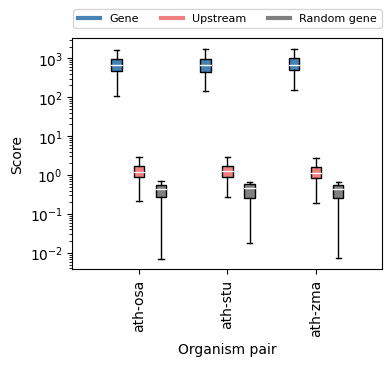

In [51]:
keys = sorted(org_distances_upstream.keys())  # Assuming all dictionaries have the same keys
keys = [k for k in keys if 'ath' in k]
# Extract values in the order of the keys and combine them for plotting
data = []
labels = []
positions = []

# Generate positions for boxplots
n_experiments = 3
position_offset = 0.25
position_index = 1

for key in keys:
    data.append(org_distances[key])
    labels.append(f'{key} Exp1')
    positions.append(position_index - position_offset)

    data.append(org_distances_upstream[key])
    labels.append(f'{key} Exp2')
    positions.append(position_index)

    data.append(org_distances_random[key])
    labels.append(f'{key} Exp3')
    positions.append(position_index + position_offset)

    position_index += 1

# Colors for each experiment
colors = ['steelblue', 'lightcoral', 'gray']

# Create the box plots
fig, ax = plt.subplots(figsize=(4, 3))
bplot = ax.boxplot(data, positions=positions, widths=0.12, patch_artist=True, showfliers=False)

# Set colors for each box
for patch, color in zip(bplot['boxes'], colors * len(keys)): patch.set_facecolor(color)
for median, color in zip(bplot['medians'], colors * len(keys)):  median.set_color('white')

# Customize the plot
ax.set_xlabel('Organism pair')
ax.set_ylabel('Score')
ax.set_xticks(np.arange(1, len(keys) + 1))
ax.set_xticklabels(keys)
plt.xticks(rotation=90)
plt.yscale('log')
# ax.set_ylim(0, 1e6)
# # Add legend

legend_elements = [Line2D([0], [0], color='steelblue', lw=3, label='Gene'),
                   Line2D([0], [0], color='lightcoral', lw=3, label='Upstream'),
                   Line2D([0], [0], color='gray', lw=3, label='Random gene')]
ax.legend(handles=legend_elements, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.15), ncol=3)

# Show the plot
plt.show()